In [1]:
%load_ext autoreload
%autoreload 2

# Simulated Cube: Motion Extraction & Material-Property Estimation
This demo walks through motion extraction and material-property inference for a simulated cube. The following files are needed:
* For motion extraction and mode identification: `simulated_data/{OBJ_NAME}/{SIM_NAME}.gif` (could be other video format besides GIF)
* For comparison to ground truth: `simulated_data/{OBJ_NAME}/true_stiffness.npy`, `simulated_data/{OBJ_NAME}/true_density.npy`

In [2]:
import os
import time

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib import cm

from utils import (read_frames, extract_motion, weighted_gaussian_smooth,
                   get_fft_results, find_peak_idxs, prompt_clicks,
                   get_cube_model, keypoints_from_clicks, gather_image_space_modes,
                   get_observed_modal_data, get_solver)
from utils import (plot_motion_field, find_nearest, normalize_modes,
                   interpolate_2d_motion, freqs_to_eigvals, projection_matrix_from_keypoints,
                   full_mode_matrix, weighted_sum, project_and_interpolate_motion,
                   plot_3d_cube)

In [26]:
OBJ_NAME = 'defect00'
SIM_NAME = 'top_front_pluck'
FPS = 2000

N_THREADS = 8  # num. threads to use in multithreaded functions

## Motion Extraction

In [4]:
"""
Read input video.
"""
gif_fn = os.path.join(
    'simulated_data', OBJ_NAME, '%s_%s.gif' % (OBJ_NAME, SIM_NAME))
video_frames = read_frames(gif_fn)

Reading frames: 100%|████████████████████████████████████████████████| 12000/12000 [00:13<00:00, 888.84it/s]


In [1]:
"""
Extract horizontal and vertical displacement fields.
This step may take a couple minutes.
`motion_fields` has the shape (2, T, H, W), where 
`motion_fields[0]` contains the horizontal displacement fields,
and `motion_fields[1]` contains the vertical displacement fields.
"""
t_start, t_end = 50, 6000  # range of frames to extract motion for
reference_frame = video_frames[t_start]
motion_fields = extract_motion(
    video_frames[t_start:t_end], reference_frame, n_threads=N_THREADS)

NameError: name 'video_frames' is not defined

In [6]:
"""
Apply amplitude-weighted Gaussian smoothing to displacement fields.
"""
sigma = 4  # std. dev. of Gaussian blur kernel, in pixels
motion_fields = weighted_gaussian_smooth(
    motion_fields, reference_frame, sigma, n_threads=N_THREADS)

Running amplitude-weighted Gaussian smoothing in 8 threads...
[Thread 0] 500 / 743 frames processed in 10.2 seconds.
Done! Elapsed time: 0:00:15.175733


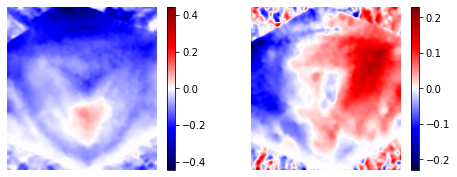

In [7]:
"""
View the displacement field at one frame.
"""
t = 1200
plt.figure(figsize=(8, 3))
plt.subplot(121)
plot_motion_field(motion_fields[0][t])

plt.subplot(122)
plot_motion_field(motion_fields[1][t])

## Mode Identification

In [8]:
"""
Run 1D FFT on displacement fields.
`fft_dx[i]` contains the FFT coefficients of horizontal motion at FFT bin i.
`fft_dy[i]` contains the FFT coefficients of vertical motion at FFT bin i.
`spectrum` is the power spectrum of horizontal + vertical motion amplitude.
`ffreqs[i]` is the frequency [Hz] of FFT bin i.
"""
max_fft_freq = 50  # max. frequency (in Hz) to consider
fft_dx, fft_dy, spectrum, ffreqs = get_fft_results(
    motion_fields, FPS, max_fft_freq, n_threads=N_THREADS)
log_spectrum = np.log(spectrum)

Running FFT in 8 threads...
[Thread 0] 5 / 51 rows processed in 0.8 seconds.
[Thread 0] 10 / 51 rows processed in 0.8 seconds.
[Thread 0] 15 / 51 rows processed in 0.9 seconds.
[Thread 0] 20 / 51 rows processed in 0.8 seconds.
[Thread 0] 25 / 51 rows processed in 1.7 seconds.
[Thread 0] 30 / 51 rows processed in 1.5 seconds.
[Thread 0] 35 / 51 rows processed in 0.8 seconds.
[Thread 0] 40 / 51 rows processed in 1.7 seconds.
[Thread 0] 45 / 51 rows processed in 0.7 seconds.
[Thread 0] 50 / 51 rows processed in 0.6 seconds.
Done! Elapsed time: 0:00:11.633555


In [9]:
"""
Find peaks in the log-power spectrum of motion amplitude.
"""
max_fft_idx = find_nearest(ffreqs, max_fft_freq)

# If undamped, recommended prominence is 0.05.
# If damped, recommended prominence is 0.01.
peak_prominence = 0.05
peak_idxs = find_peak_idxs(log_spectrum[:max_fft_idx], prominence=peak_prominence)

plt.figure(figsize=(8, 5))
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(
    ffreqs[peak_idxs], log_spectrum[peak_idxs],
    color='orange', label='Peaks', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')
plt.show()

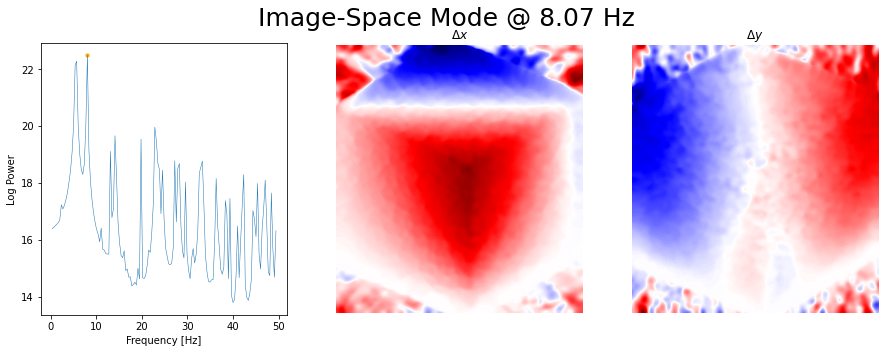

In [11]:
"""
View a specified image-space mode.
"""
fft_idx = peak_idxs[1]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta$$x$')
plt.axis('off')

plt.subplot(133)
plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta$$y$')
plt.axis('off')
plt.show()

## Cube Model

In [12]:
XLEN, YLEN, ZLEN = 0.05, 0.05, 0.05  # dimensions of the cube, in meters
NX, NY, NZ = 8, 8, 8  # num. of voxels in each direction
NU = 0.3  # homogeneous Poisson's ratio
ELEMENT_ORDER = 1  # mesh element order (a.k.a. degree)

In [13]:
cube = get_cube_model(XLEN, YLEN, ZLEN, NX, NY, NZ, NU, ELEMENT_ORDER)

Element mass mats: 100%|██████████████████████████████████████████████████| 512/512 [00:05<00:00, 96.19it/s]


### Locate keypoints (i.e., visible mesh vertices) in the image

<IPython.core.display.Javascript object>


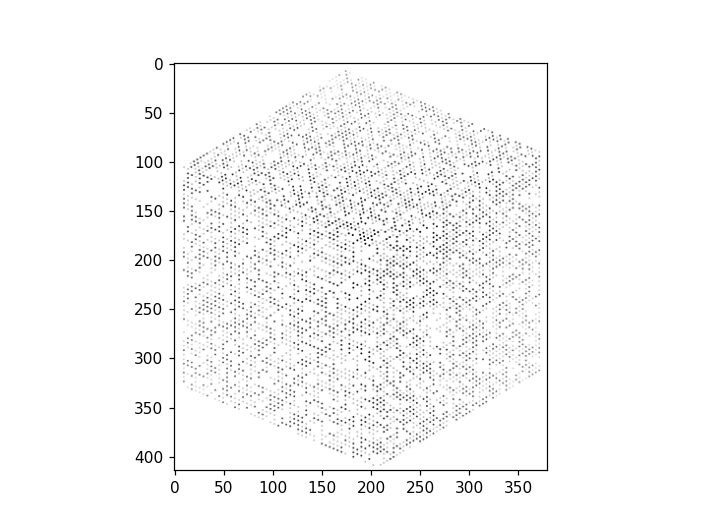

In [14]:
# Click the following points in the given order:
# 1. bottom left
# 2. bottom middle
# 3. bottom right
# 4. top left back
# 5. top left front
# 6. top right back
# 7. top right front

%matplotlib notebook
clicks = []
prompt_clicks(reference_frame, clicks, cmap='gray')

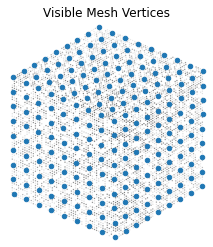

In [15]:
plt.close('all')
%matplotlib inline
keypoints = keypoints_from_clicks(clicks, NX, NY, NZ)

plt.imshow(reference_frame, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20)
plt.axis('off')
plt.title('Visible Mesh Vertices')
plt.show()

### Sample image-space modes at keypoints

In [16]:
# Gather image-space modes from peak indices.
image_space_modes_dx, image_space_modes_dy = gather_image_space_modes(
    fft_dx, fft_dy, peak_idxs)

# Get mode matrix, where only the DOFs visible in image-space
# are filled with the observed (projected) mode shape.
U_observed = get_observed_modal_data(
    image_space_modes_dx, image_space_modes_dy,
    keypoints, cube.n_dofs, cube.image_space_dofs)
# Set bottom DOFs to 0.
U_observed[cube.bc_dofs] = 0
# Normalize modes.
U_observed = normalize_modes(U_observed)

# Get observed frequencies.
freqs_observed = ffreqs[peak_idxs]
eigvals_observed = freqs_to_eigvals(freqs_observed)

### Visualize image-space modes as interpolated between keypoints

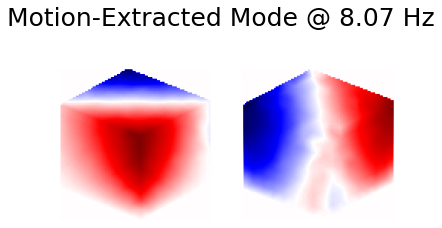

In [17]:
mode_idx = 1
mode_freq = freqs_observed[mode_idx]
mode_2d = U_observed[cube.image_space_dofs, mode_idx].reshape(-1, 3)[:, :2]
mode_dx, mode_dy = interpolate_2d_motion(keypoints, mode_2d)

fig = plt.figure()
fig.suptitle(
    'Motion-Extracted Mode @ %.2f Hz' % mode_freq,
    fontsize=25)
plt.subplot(121)
plot_motion_field(mode_dx, cbar=False)

plt.subplot(122)
plot_motion_field(mode_dy, cbar=False)
plt.show()

## Inference

### Initialize solver

In [18]:
# Estimate 3d-to-2d projection matrix from the keypoints.
proj_mat = projection_matrix_from_keypoints(cube, keypoints)

# Initialize solver.
solver = get_solver(cube, proj_mat)

Gather element mats: 100%|███████████████████████████████████████████████| 512/512 [00:00<00:00, 863.86it/s]


In [23]:
# Set the inputs to the solver.
input_modes = np.arange(len(eigvals_observed))  # mode indices to include in optimization
n_modes = len(input_modes)  # num. of modes to give solver

U_input = U_observed[cube.nonbc_dofs][:, input_modes]
eigvals_input = eigvals_observed[input_modes]
solver.update_observations(U_input, eigvals_input)
print('num. of given image-space modes: %d' % solver.k)

num. of given image-space modes: 19


### Run solver

In [24]:
# Set hyperparameters.
w_init = 9000  # initial homog. Young's modulus (in Pa)
v_init = 1270   # initial homog. density (in kg/m3)
if n_modes >= 10:
    solver.params['alpha_u'] = 10  # data-term weight
else:
    solver.params['alpha_u'] = 1
n_vox = NX * NY * NZ
solver.params['alpha_w'] = 1e-10 / n_vox  # smoothness reg. weight on w
solver.params['alpha_v'] = 1e-7 / n_vox   # smoothness reg. weight on v
solver.params['alpha_e'] = 1              # eigenvalue-data-term weight
solver.params['alpha_w_mean'] = 1  # mean-value reg. weight on w
solver.params['alpha_v_mean'] = 0  # mean-value reg. weight on v
solver.params['w_mean'] = w_init   # target mean value of w
solver.params['v_mean'] = v_init   # target mean value of v
eta = 1  # dual-variable update rate
norm_converge_thresh = 1e-3  # threshold of convergence

KeyboardInterrupt: 

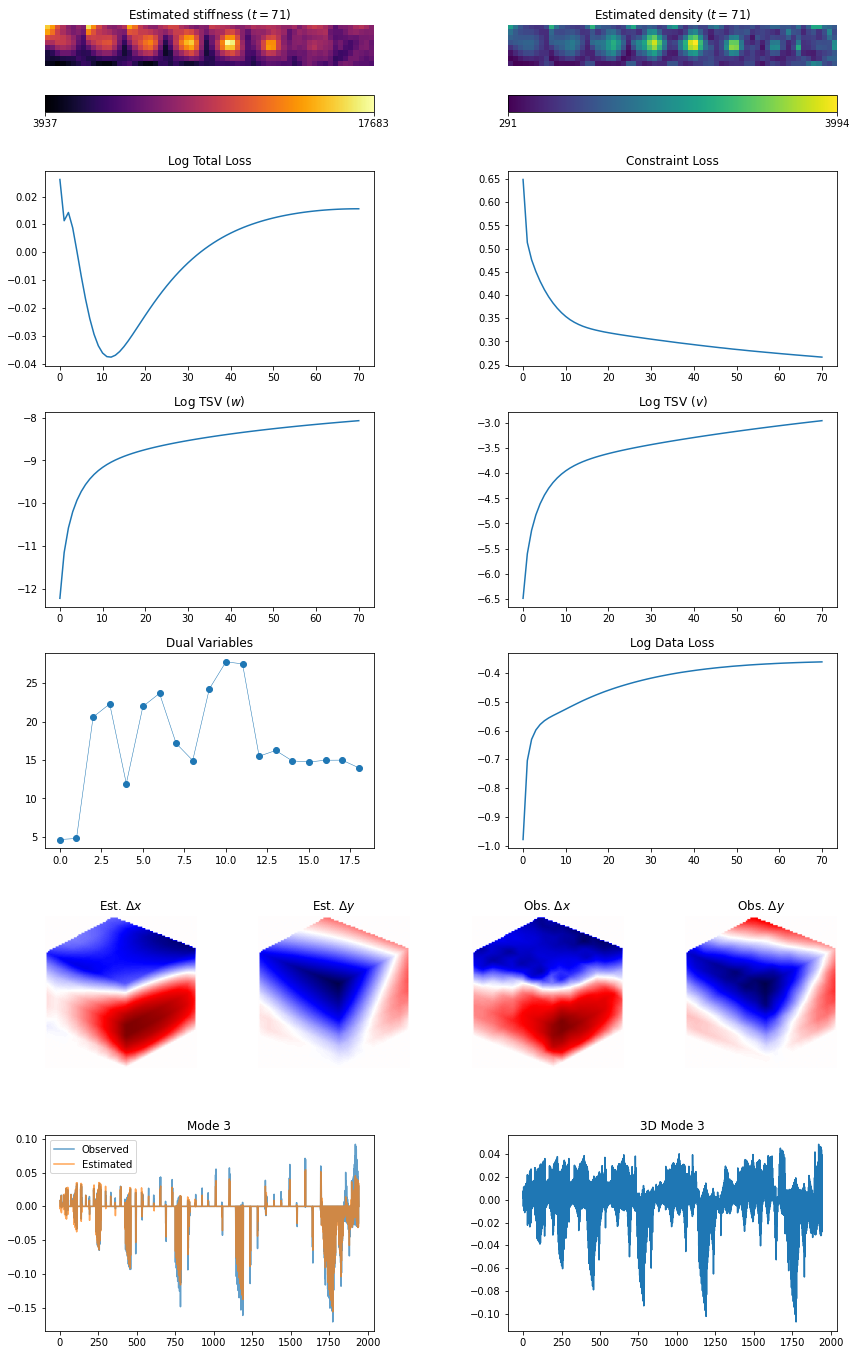

In [25]:
initialize = True
n_iter = 100

Uo_full = full_mode_matrix(solver.Uo, cube.n_dofs, cube.nonbc_dofs)

if initialize:
    Ut = solver.Uo.copy()
    evalst = solver.evals_observed.copy()
    wt = np.ones(n_vox) * w_init
    vt = np.ones(n_vox) * v_init
    
    Kt = weighted_sum(solver.element_stiffness_mats, wt)
    Mt = weighted_sum(solver.element_mass_mats, vt)
    
    dual_vars = np.ones(solver.k)
    
    losses_dict = {
        'total': [],
        'constr': [],
        'constr_unw': [],
        'data': [],
        'eigval_data': [],
        'tsv_w': [],
        'tsv_v': [],
        'scale_reg': []
    }
    fig_ims = []
    
w_prev, v_prev = wt, vt
start_t = len(losses_dict['total'])
for t in range(start_t, start_t + n_iter):
    iter_start = time.time()
    
    # Solve modes.
    Ut = solver.solve_U(Kt, Mt, evalst, dual_vars)
    
    # Solve eigenvalues.
    evalst = solver.solve_evals(Kt, Mt, Ut, dual_vars)
    
    # Update dual variables.
    dual_vars = solver.update_dual_vars(Kt, Mt, Ut, evalst, dual_vars, eta)
    
    # Solve material properties.
    wv = solver.solve_w_v(
        Ut, evalst, dual_vars,enforce_pos=True)
    wt = wv[:solver.n_weights]
    vt = wv[solver.n_weights:]
    Kt = weighted_sum(solver.element_stiffness_mats, wt)
    Mt = weighted_sum(solver.element_mass_mats, vt)
    
    # Update losses.
    unw_loss_dict, loss_dict = solver.loss(Ut, evalst, Kt, Mt, wt, vt, dual_vars)
    for loss_term in loss_dict.keys():
        losses_dict[loss_term].append(loss_dict[loss_term])
    losses_dict['constr_unw'].append(unw_loss_dict['constr'])
        
    # Check solution convergence.
    w_residual = wt - w_prev
    v_residual = vt - v_prev
    w_residual_norm = np.linalg.norm(w_residual) / np.linalg.norm(w_prev)
    v_residual_norm = np.linalg.norm(v_residual) / np.linalg.norm(v_prev)
    if w_residual_norm <= norm_converge_thresh and v_residual_norm <= norm_converge_thresh:
        print('Converged! (w residual norm = %.6f, v residual norm = %.6f)'
              % (w_residual_norm, v_residual_norm))
        break
    w_prev, v_prev = wt, vt
    
    # Plot progress.
    Ut_full = full_mode_matrix(Ut, cube.n_dofs, cube.nonbc_dofs)
    Ut_proj = solver.P @ Ut
    
    fig = plt.figure(figsize=(12, 20))
    
    plt.subplot(621)
    cube.plot_2d(wt, cmap='inferno')
    plt.axis('off')
    plt.title("Estimated stiffness ($t=%d$)" % (t+1))
    
    plt.subplot(622)
    cube.plot_2d(vt, cmap='viridis')
    plt.axis('off')
    plt.title("Estimated density ($t=%d$)" % (t+1))
    
    # Plot losses.
    plt.subplot(623)
    plt.plot(np.log(losses_dict['total']))
    plt.title('Log Total Loss')
    
    plt.subplot(624)
    plt.plot(losses_dict['constr'])
    plt.title('Constraint Loss')
    
    plt.subplot(625)
    plt.plot(np.log(losses_dict['tsv_w']))
    plt.title('Log TSV ($w$)')
    
    plt.subplot(626)
    plt.plot(np.log(losses_dict['tsv_v']))
    plt.title('Log TSV ($v$)')
    
    plt.subplot(627)
    plt.plot(dual_vars, linewidth=0.5)
    plt.scatter(np.arange(solver.k), dual_vars)
    plt.title('Dual Variables')
    
    ax = fig.add_subplot(6, 2, 8)
    ax.plot(np.log(losses_dict['data']))
    ax.set_title('Log Data Loss')

    # Visualize random mode.
    i = np.random.randint(0, solver.k)
    
    # Estimated mode:
    est_mode_3d = Ut_full[cube.image_space_dofs, i].reshape(-1, 3)
    est_mode_dx, est_mode_dy = project_and_interpolate_motion(
        keypoints, est_mode_3d, proj_mat)
    
    ax = fig.add_subplot(6, 4, 17)
    plot_motion_field(est_mode_dx, fig=fig, ax=ax, cbar=False)
    ax.set_title('Est. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 18)
    plot_motion_field(est_mode_dy, fig=fig, ax=ax, cbar=False)
    ax.set_title('Est. $\Delta$$y$')
    
    # Observed mode:
    obs_mode_2d = Uo_full[cube.image_space_dofs, i].reshape(-1, 3)[:, :2]
    obs_mode_dx, obs_mode_dy = interpolate_2d_motion(
        keypoints, obs_mode_2d)
    
    ax = fig.add_subplot(6, 4, 19)
    plot_motion_field(obs_mode_dx, fig=fig, ax=ax, cbar=False)
    ax.set_title('Obs. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 20)
    plot_motion_field(obs_mode_dy, fig=fig, ax=ax, cbar=False)
    ax.set_title('Obs. $\Delta$$y$')
    
    # 1d mode comparison:
    ax = fig.add_subplot(6, 2, 11)
    ax.plot(solver.Uo[:, i], alpha=0.7, label='Observed')
    ax.plot(Ut_proj[:, i], alpha=0.7, label='Estimated')
    ax.legend()
    ax.set_title('Mode %d' % i)
    
    # 3d mode:
    ax = fig.add_subplot(6, 2, 12)
    ax.plot(Ut[:,i] / np.linalg.norm(Ut[:,i]))
    ax.set_title('3D Mode %d' % i)
    
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(plt.gcf())
    plt.close('all')
    
    print('[t=%03d] %.3f sec, w residual norm: %.6f, v residual norm: %.6f'
          % (t, time.time() - iter_start, w_residual_norm, v_residual_norm))

### Compare results to the true material properties

In [27]:
# Forward model uses a 10x10x10 hexahedral mesh.
cube_forward = get_cube_model(XLEN, YLEN, ZLEN, 10, 10, 10, NU, ELEMENT_ORDER)

# Load true properties.
true_w = np.load('simulated_data/%s/true_stiffness.npy' % OBJ_NAME)
true_v = np.load('simulated_data/%s/true_density.npy' % OBJ_NAME)

Element mass mats: 100%|███████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.84it/s]


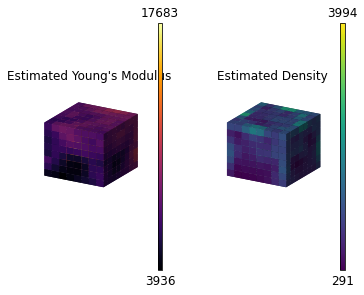

In [55]:
fig = plt.figure(figsize=(6, 20))

pad_height = 1
elev = 20
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("Estimated Young's Modulus")
plot_3d_cube(cube, wt, cmap=cm.inferno, pad_height=pad_height, elev=elev, fig=fig, ax=ax)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("Estimated Density")
plot_3d_cube(cube, vt, cmap=cm.viridis, pad_height=pad_height, elev=elev, fig=fig, ax=ax)
plt.show()

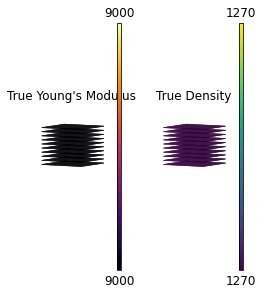

In [29]:
fig = plt.figure(figsize=(4, 20))

pad_height = 7
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("True Young's Modulus")
plot_3d_cube(cube_forward, true_w, cmap=cm.inferno, pad_height=pad_height, fig=fig, ax=ax)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("True Density")
plot_3d_cube(cube_forward, true_v, cmap=cm.viridis, pad_height=pad_height, fig=fig, ax=ax)
plt.show()